In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import os,sys
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt


%matplotlib inline  

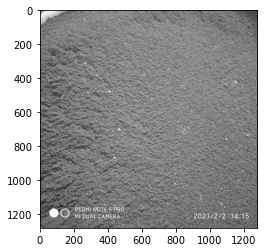

In [23]:
img = cv2.imread('10_per_adul/IMG-20210202-WA0108.jpg')
image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

In [24]:
def crop_photo_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=1)
    thresh = cv2.dilate(thresh, None, iterations=1)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Step 6:Cropped Image')
        
        plt.show()
    
    return new_image

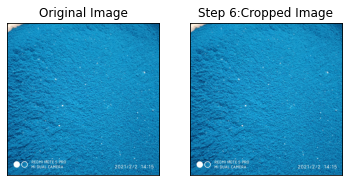

In [25]:
ex_img = cv2.imread('10_per_adul/IMG-20210202-WA0108.jpg')
ex_new_img = crop_photo_contour(ex_img,True)

In [26]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(os.path.join(directory,filename))
            # load the image
            # crop the photo and ignore the unnecessary rest part of the image
            #image = crop_photo_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array
            if directory == '10_per_adul':
                y.append([1])
            elif directory == '15_per_adul':
                y.append([2])
            elif directory == '20_per_adul':
                y.append([3])
            elif directory == '25_per_adul':
                y.append([4])
            elif directory == '30_per_adul':
                y.append([5])
            elif directory == 'pure':
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
      
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [27]:
ten_per = '10_per_adul'
fifteen_per= '15_per_adul'
twenty_per= '20_per_adul'
twentyfive_per= '25_per_adul'
thirty_per= '30_per_adul'
pure= 'pure'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([ten_per,fifteen_per,twenty_per,twentyfive_per,thirty_per,pure], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 278
X shape is: (278, 224, 224, 3)
y shape is: (278, 1)


In [28]:
def plot_sample_images(X, y, n=5):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1,2,3,4,5]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        if (label == 1):
            label_to_str="10_per_adultered"
        elif (label==2):
            label_to_str="15_per_adultered"
        elif (label==3):
            label_to_str="20_per_adultered"
        elif (label==4):
            label_to_str="25_per_adultered"
        elif (label==5):
            label_to_str="30_per_adultered"
        else:
            label_to_str="pure"
            
        
        plt.suptitle(f"turmeric powder: {label_to_str}")
        plt.show()

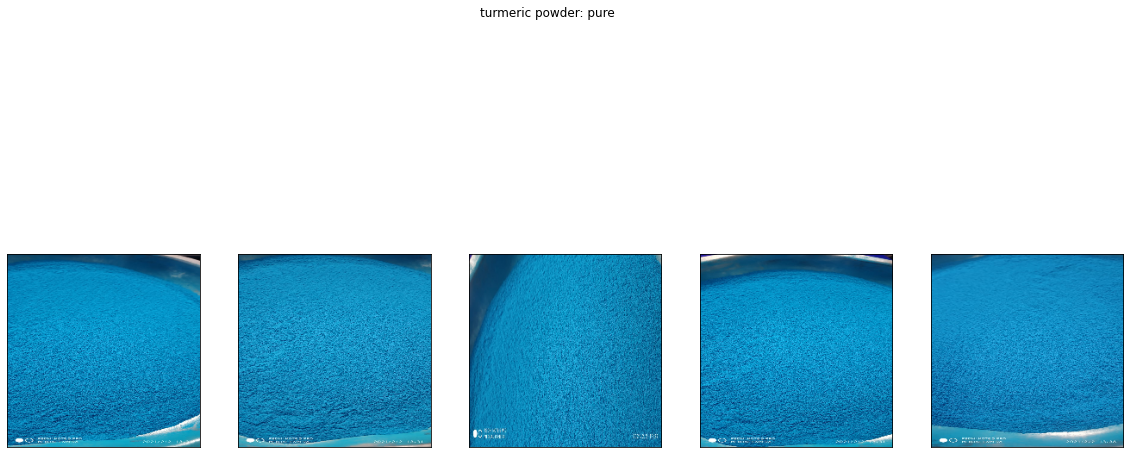

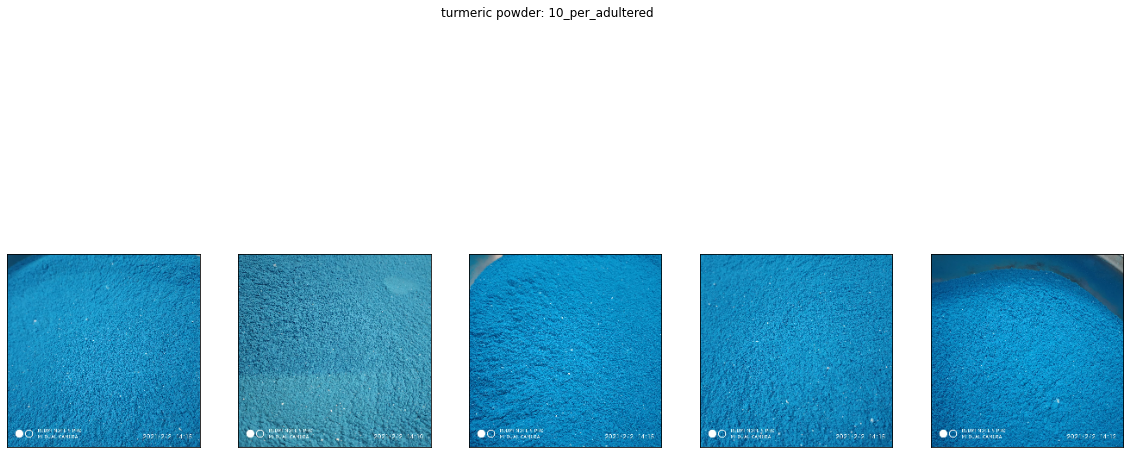

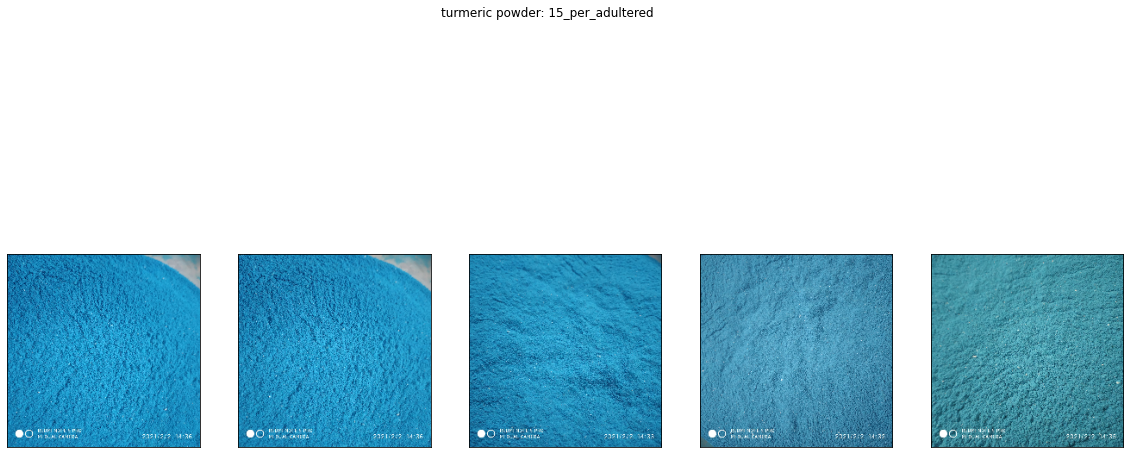

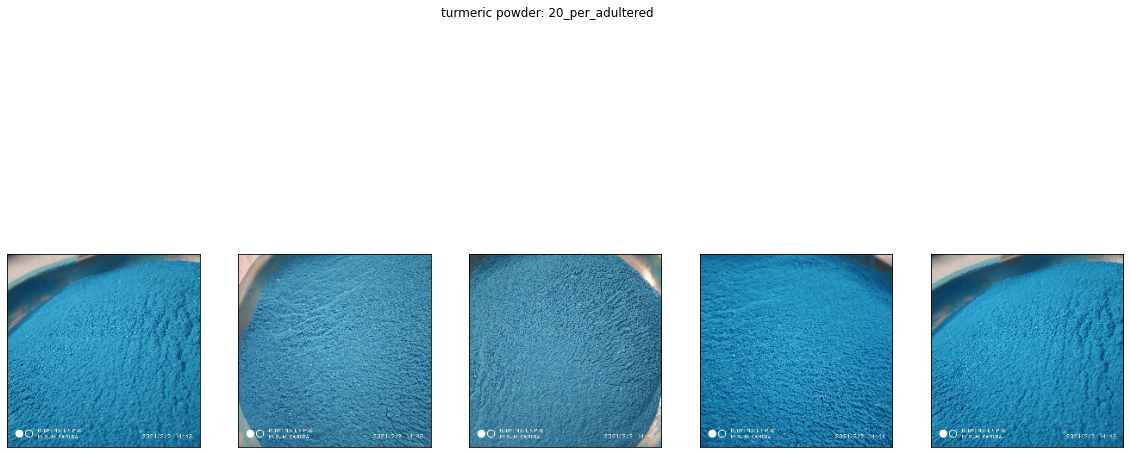

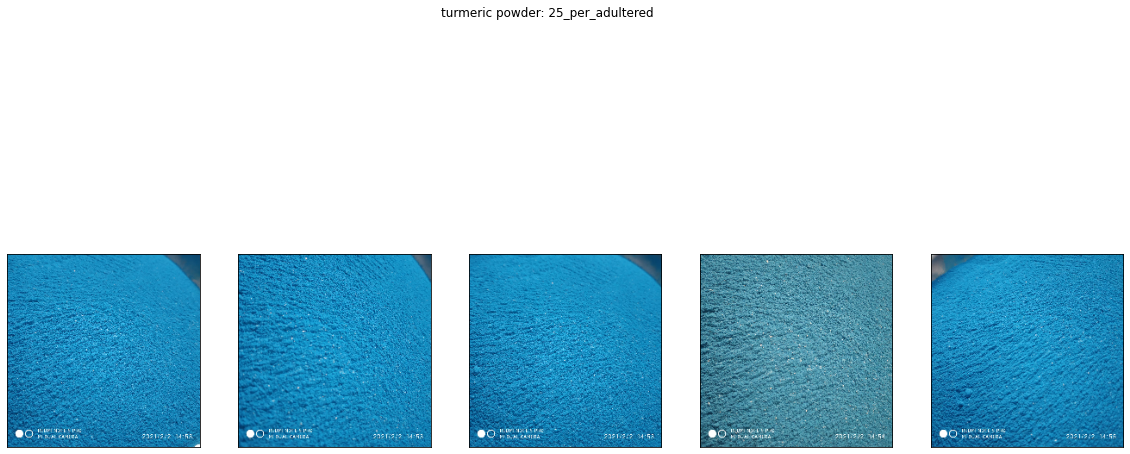

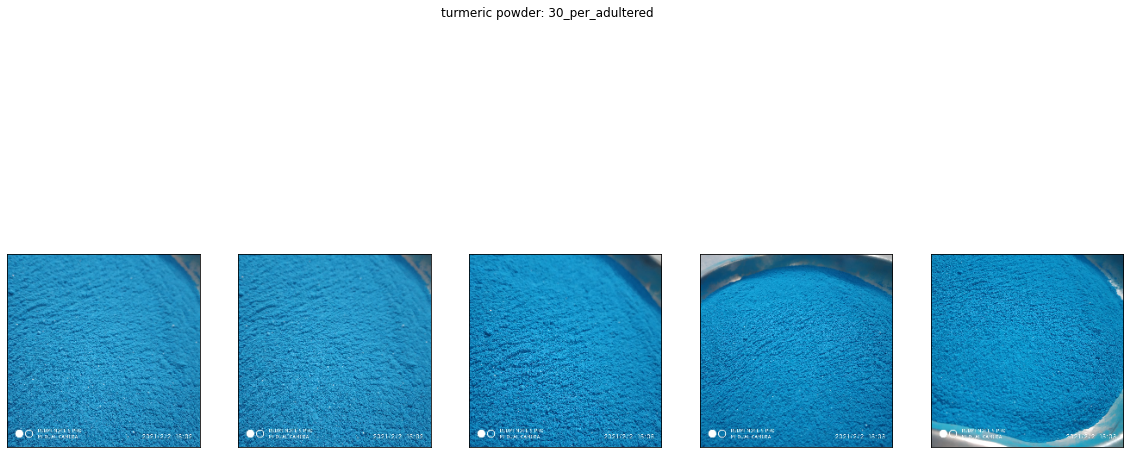

In [29]:
plot_sample_images(X, y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 222
number of test examples = 56
X_train shape: (222, 224, 224, 3)
Y_train shape: (222, 1)
X_test shape: (56, 224, 224, 3)
Y_test shape: (56, 1)


In [32]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

In [34]:
model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=1000, activation="relu"))
model.add(Dense(units=6, activation="softmax"))

In [35]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.00001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Abhishek\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

In [37]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [38]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [39]:
#tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
#tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')
early=EarlyStopping(monitor='val_accuracy',min_delta=0,patience=25,verbose=1,mode='auto')

In [40]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto'))

In [41]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=8, epochs=20, validation_data=(X_test, y_test), callbacks=[early, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/20
28/28 [==============================] - 191s 7s/step - loss: 1.7914 - accuracy: 0.1847 - val_loss: 1.7706 - val_accuracy: 0.2679
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.27.model\assets
Epoch 2/20
28/28 [==============================] - 194s 7s/step - loss: 1.7804 - accuracy: 0.2342 - val_loss: 1.7107 - val_accuracy: 0.2679
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.27.model\assets
Epoch 3/20
28/28 [==============================] - 197s 7s/step - loss: 1.7487 - accuracy: 0.2342 - val_loss: 1.6728 - val_accuracy: 0.2679
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.27.model\assets
Epoch 4/20
28/28 [==============================] - 199s 7s/step - loss: 1.6817 - accuracy: 0.2748 - val_loss: 1.6184 - val_accuracy: 0.2321
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.23.model\assets
Epoch 5/20
28/28 [==============================] - 199s 7s/step - loss: 1.6

In [43]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=8, epochs=10, validation_data=(X_test, y_test), callbacks=[early, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
28/28 [==============================] - 220s 8s/step - loss: 0.8132 - accuracy: 0.6622 - val_loss: 1.1802 - val_accuracy: 0.6429
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.64.model\assets
Epoch 2/10
28/28 [==============================] - 226s 8s/step - loss: 0.6562 - accuracy: 0.7658 - val_loss: 1.1955 - val_accuracy: 0.6429
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.64.model\assets
Epoch 3/10
28/28 [==============================] - 220s 8s/step - loss: 0.6155 - accuracy: 0.7658 - val_loss: 1.1197 - val_accuracy: 0.6429
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.64.model\assets
Epoch 4/10
28/28 [==============================] - 222s 8s/step - loss: 0.5217 - accuracy: 0.7883 - val_loss: 1.1468 - val_accuracy: 0.7143
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.71.model\assets
Epoch 5/10
28/28 [==============================] - 217s 8s/step - loss: 0.4

In [44]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=8, epochs=10, validation_data=(X_test, y_test), callbacks=[early, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
28/28 [==============================] - 202s 7s/step - loss: 0.5031 - accuracy: 0.8333 - val_loss: 1.1270 - val_accuracy: 0.7321
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.73.model\assets
Epoch 2/10
28/28 [==============================] - 209s 7s/step - loss: 0.3958 - accuracy: 0.8694 - val_loss: 1.3157 - val_accuracy: 0.7857
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.79.model\assets
Epoch 3/10
28/28 [==============================] - 213s 8s/step - loss: 0.3968 - accuracy: 0.8739 - val_loss: 1.2264 - val_accuracy: 0.7857
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.79.model\assets
Epoch 4/10
28/28 [==============================] - 215s 8s/step - loss: 0.3063 - accuracy: 0.8919 - val_loss: 1.2446 - val_accuracy: 0.8214
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.82.model\assets
Epoch 5/10
28/28 [==============================] - 225s 8s/step - loss: 0.2

In [45]:
model.save('VGGmodel2.h5')

In [46]:
history = model.history.history

In [47]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [48]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

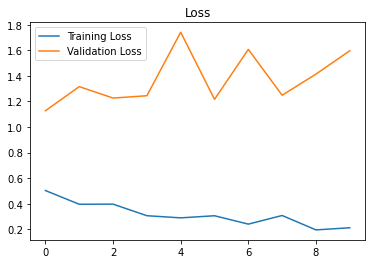

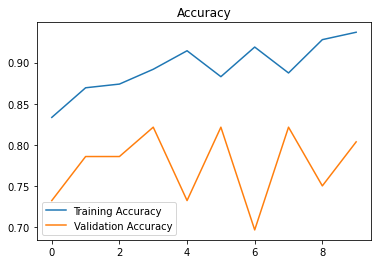

In [49]:
plot_metrics(history)

In [51]:
%matplotlib inline

image = keras.preprocessing.image
model = keras.models.load_model('VGGmodel2.h5')
#path to any image to be predicted
path = 'pure/IMG-20210202-WA0060.jpg'
img = image.load_img(path, target_size=(244, 244))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#[x] can be an array of images 
images = np.vstack([x])
classes = model.predict(images, batch_size=8)
print(classes)

[[0. 0. 0. 0. 0. 1.]]
